## Arabic Handwritten Characters Classification
---

### I. Objectifs:
- Classification de caractères arabes écrits à la main
- Déterminer le meilleur classificateur pour cette tâche parmi ceux vus lors du cours de machine learning

### II. Données:
- **Source**: Kaggle, ["Arabic Handwritten Characters Dataset"](https://www.kaggle.com/datasets/mloey1/ahcd1/data)
- **Description des fichiers**:
    - Un fichier CSV contenant les images de caractères arabes écrits à la main pour l'entraînement.
    - Un fichier CSV contenant les labels associés aux images d'entraînement.
    - Un fichier CSV contenant les images de caractères arabes écrits à la main pour la validation.
    - Un fichier CSV contenant les labels associés aux images de validation.

### III. Méthodologie:
1. **Exploration des Données**:
   - Analye descriptive rapide des données
   - Visualisation d'exemples de caractères manuscrits pour vérifier leur qualité.
2. **Prétraitement des Données**:
   - Vérification et traitement des éventuelles données manquantes.
   - Normalisation des valeurs des pixels pour améliorer l'apprentissage.
3. **Modélisation**:
   - Test de plusieurs classificateurs, tels que :
     - Regression Logistique (benchmark model)
     - Arbres de décision
     - RandomForest (exemple de bagging)
     - Adaboost (exemple de boosting)
   - Optimisation des hyperparamètres pour chaque modèle.
4. **Évaluation**:
   - Utilisation de méthodes de cross validation pour éviter le sur-ajustement et obtenir des qualités d'ajustement généralisables
   - Validation et évaluation finale des modèles sur les données de test

### IV. Résultats Attendus:
- Identifier le modèle offrant la meilleure performance pour la classification des caractères manuscrits arabes.
- Proposer des pistes d'améliorations

---

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
from joblib import Parallel, delayed
warnings.filterwarnings("ignore")

# Lecture des données
---
<br>

In [ ]:
path = "data"
list_file = os.listdir(path)
csv_file = []
for x in list_file :
    if x.endswith(".csv"):
        csv_file.append(x)
        
X_train, X_test, y_train, y_test = [],[],[],[]

for file_name in csv_file:
    with open (path + "/" + file_name, "r") as file:
        lines = file.readlines()
        for line in lines:
            line = line.strip()
            line = line.split(",")
            if file_name == "csvTrainImages 13440x1024.csv":
                line = [float (x) for x in line]
                X_train.append(line)
            elif file_name == "csvTestImages 3360x1024.csv":
                line = [float (x) for x in line]
                X_test.append(line)
            elif file_name == "csvTrainLabel 13440x1.csv":
                line = [int (x) for x in line]
                y_train.append(line)
            else:
                line = [int (x) for x in line]
                y_test.append(line)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
y_train = np.array(y_train)
data = pd.DataFrame(np.concatenate((X_train, X_test), axis=0))
label= np.concatenate((y_train,y_test), axis=0)
df_w = pd.concat([data, pd.DataFrame(label)], axis=1)
num_features = data.shape[1]  
columns = list(range(num_features)) + [1024]
df_w.columns = columns

# I - Exploratoire la base de donnée
---
<br>

## 1. Statistique descriptive

In [3]:
def explore_data(df):
    print("--- Dimensions du DataFrame ---")
    print(f"Lignes : {df.shape[0]}, Colonnes : {df.shape[1]}\n")

    print("--- Vérification des valeurs manquantes ---")
    print(df.isnull().sum().sum(), "valeurs manquantes\n")
    
explore_data(df_w)

--- Dimensions du DataFrame ---
Lignes : 16800, Colonnes : 1025

--- Vérification des valeurs manquantes ---
0 valeurs manquantes



## 2. Distribution des pixels dans l’ensemble des images

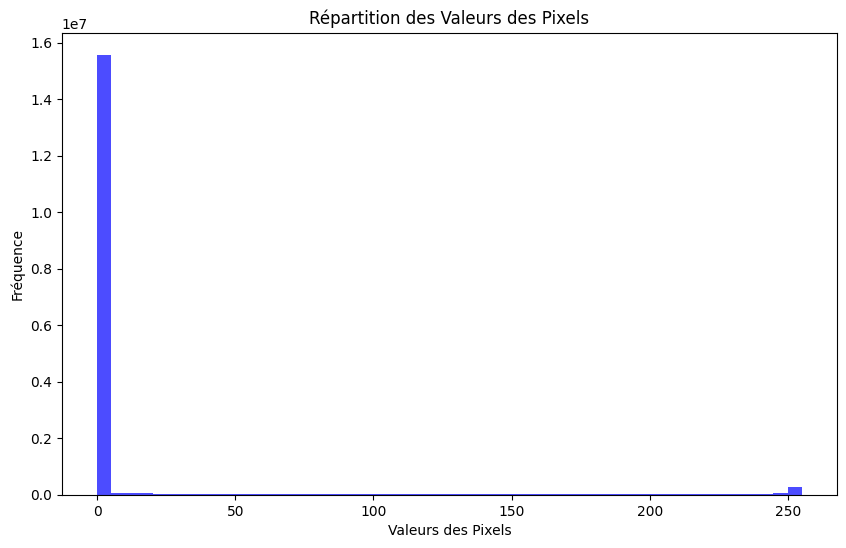

In [4]:
def plot_pixel_distribution(df):
    pixel_values = df.iloc[:, :-1].values.flatten().astype(float)
    plt.figure(figsize=(10, 6))
    plt.hist(pixel_values, bins=50, color='blue', alpha=0.7)
    plt.title("Répartition des Valeurs des Pixels")
    plt.xlabel("Valeurs des Pixels")
    plt.ylabel("Fréquence")
    plt.show()
plot_pixel_distribution(df_w)

Les données ici sont de dimension 1024, car elles représentent les images aplaties sous forme de vecteurs de 1024 pixels. Les valeurs des pixels varient entre 0 et 255, correspondant à des niveaux de gris. Donc, on normalise les données pour ramener ces valeurs dans une échelle comprise entre 0 et 1, ce qui facilite l'entraînement du modèle et améliore sa convergence.

In [5]:
df_w.loc[:,:1023] = df_w.loc[:,:1023] / 255

## 3. Distribution des classes dans le traine set et test set

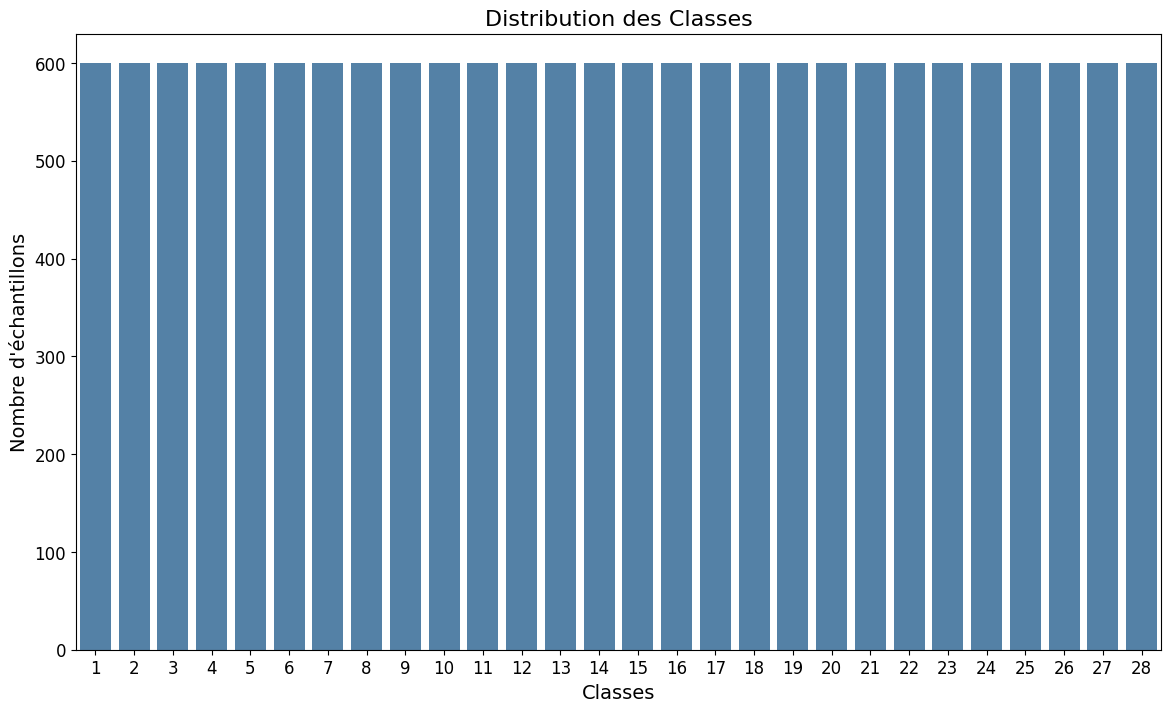

In [6]:
def plot_class_distribution_from_label(label):
    df_labels = pd.DataFrame(label, columns=["Label"])
    plt.figure(figsize=(14, 8))
    sns.countplot(data=df_labels, x="Label", color='steelblue')
    plt.title("Distribution des Classes", fontsize=16)
    plt.xlabel("Classes", fontsize=14)
    plt.ylabel("Nombre d'échantillons", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()
plot_class_distribution_from_label(label)


On observe que notre jeu de données présente des classes équilibrées. Ainsi, lors de la validation croisée, il n'est pas nécessaire d'utiliser des techniques spécifiques pour gérer un déséquilibre des classes.

## 4. Visualisation d’un exemple d’écriture manuscrite de chaque class

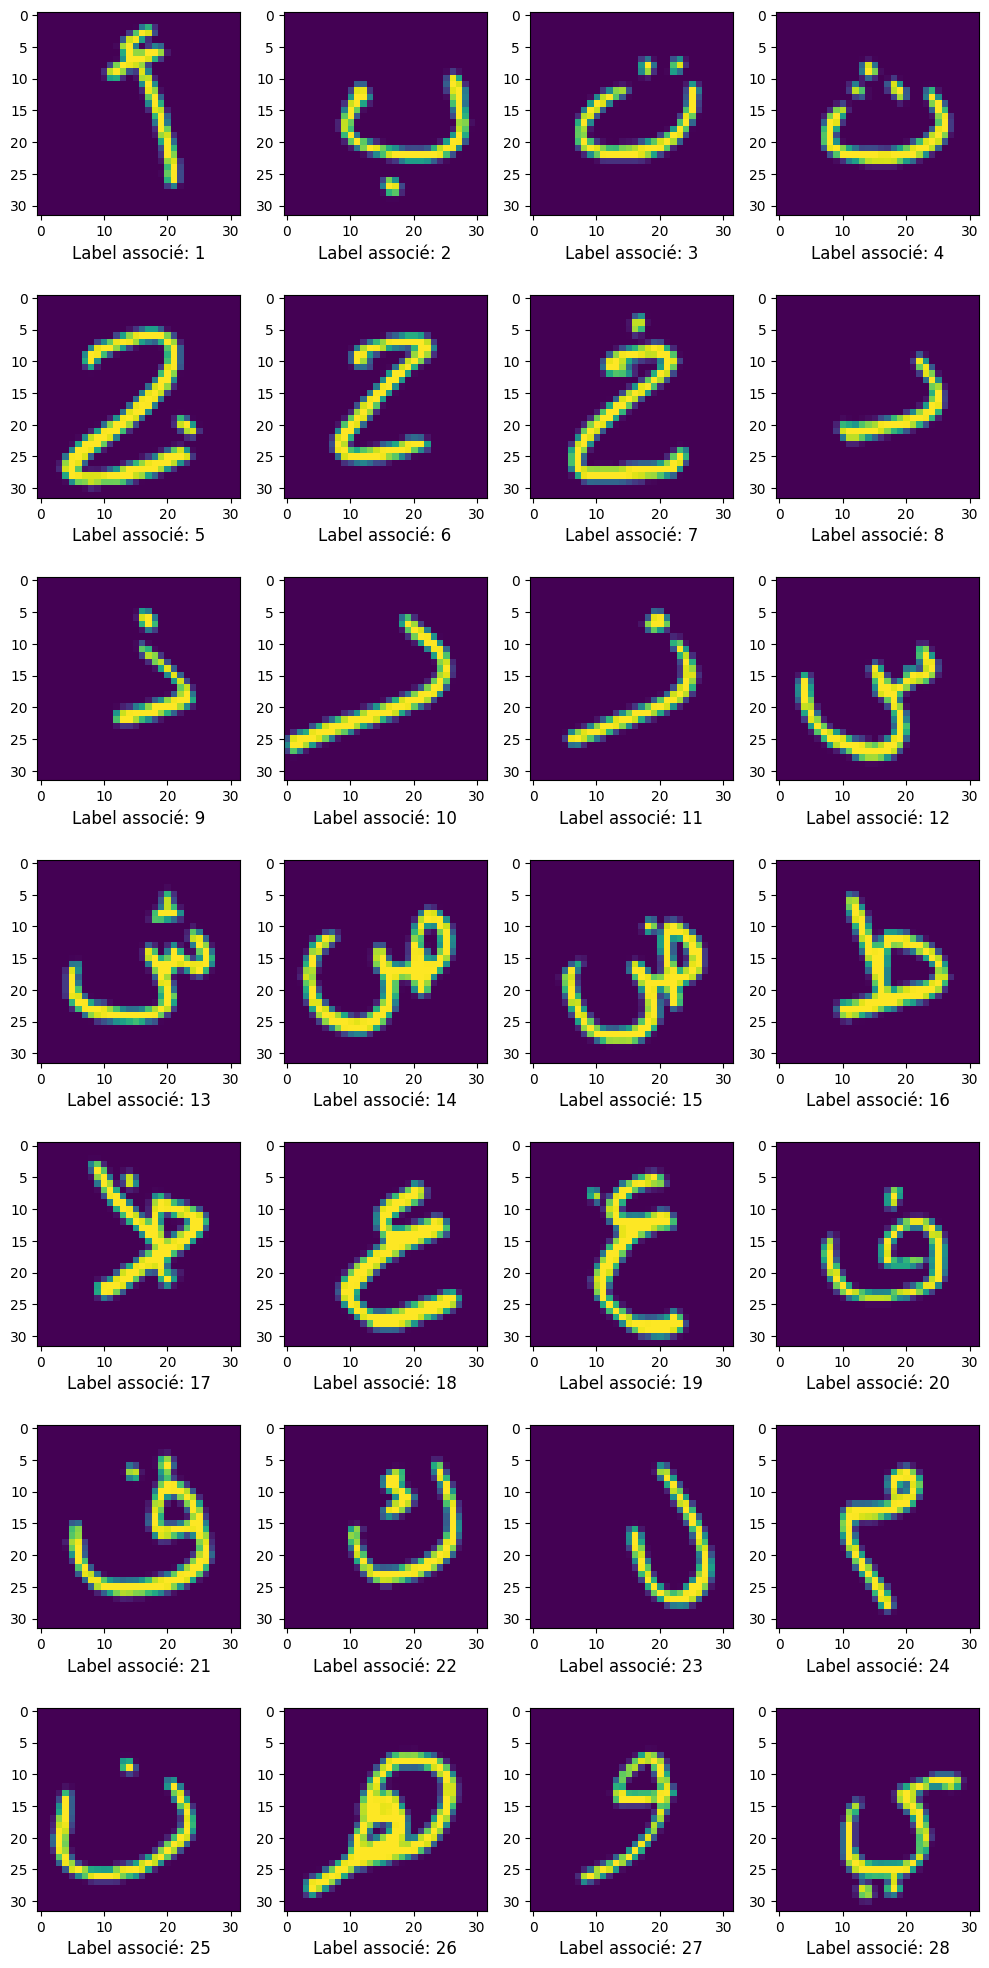

In [7]:
df_28_carac = df_w.drop_duplicates(subset=df_w.columns[-1]).reset_index(drop=True)
plt.figure(figsize=(10, 20))
for i in range(df_28_carac.shape[0]):
    plt.subplot(7, 4, i + 1)
    plt.imshow(np.array(df_28_carac.iloc[i, 0: -1],dtype= float).reshape((32, 32)).T)
    plt.xlabel(f"Label associé: {df_28_carac.iloc[i, -1]}", fontdict={'size': 12}) 
plt.tight_layout()
plt.show()

## 5. Visualisation la moyenne de l’intensité de chaque pixel

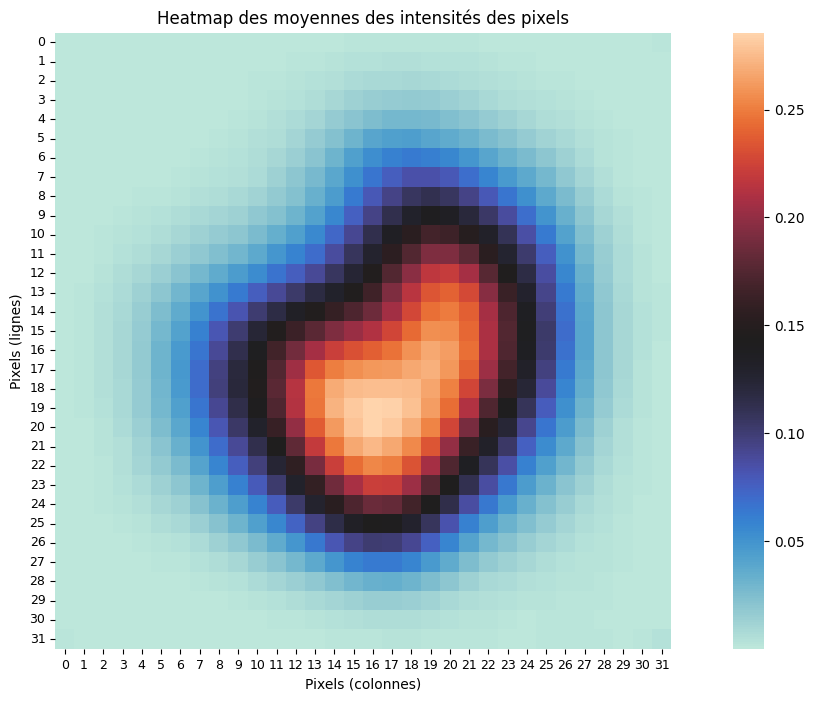

In [8]:
moyenne_pixels = df_w.iloc[:, :1024].mean(axis=0).values.reshape(32, 32)
plt.figure(figsize=(16, 8))
sns.heatmap(moyenne_pixels, cmap='icefire', square=True, cbar=True)
plt.xticks(rotation=0, fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.title("Heatmap des moyennes des intensités des pixels", fontsize=12)
plt.xlabel("Pixels (colonnes)", fontsize=10)
plt.ylabel("Pixels (lignes)", fontsize=10)
plt.show()

D’après cette heatmap, on observe que les pixels les plus intéressants, c’est-à-dire ceux qui contiennent le plus d’informations, se situent au centre de l’image.

## 6. Moyenne et écart-type des pixels pour les images

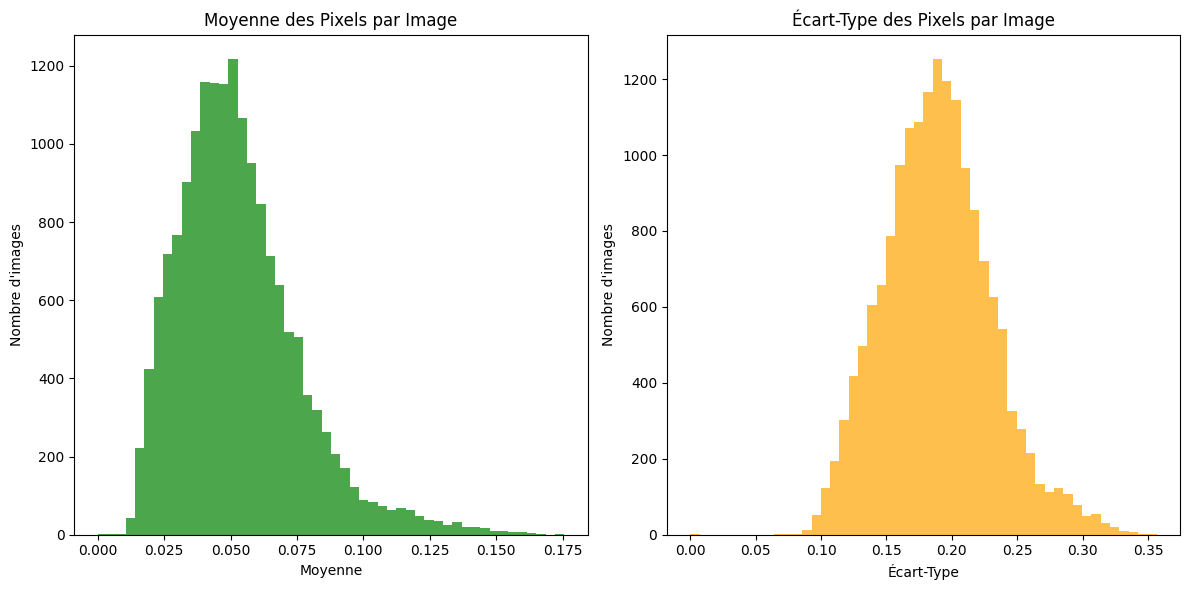

In [9]:
def pixel_variability(df):
    pixel_mean = df.iloc[:, :-1].astype(float).mean(axis=1)
    pixel_std = df.iloc[:, :-1].astype(float).std(axis=1)
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(pixel_mean, bins=50, color='green', alpha=0.7)
    plt.title("Moyenne des Pixels par Image")
    plt.xlabel("Moyenne")
    plt.ylabel("Nombre d'images")

    plt.subplot(1, 2, 2)
    plt.hist(pixel_std, bins=50, color='orange', alpha=0.7)
    plt.title("Écart-Type des Pixels par Image")
    plt.xlabel("Écart-Type")
    plt.ylabel("Nombre d'images")

    plt.tight_layout()
    plt.show()

pixel_variability(df_w)

# II. Séparation du jeu de données
---
<br>
Le jeu de données analysé ici est déjà scindé en un ensemble d'apprentissage (`X_train`, `y_train`) et un ensemble de test (`X_test`, `y_test`). Cependant, pour des raisons académiques, nous avons fusionné les ensembles `X_train` et `X_test`, ainsi que `y_train` et `y_test`. De plus, pour assurer que la proportion des classes respecte la répartition originale (c'est-à-dire équilibrée), nous utiliserons l'argument `stratify`.


In [10]:
from sklearn.model_selection import train_test_split
data = df_w.drop(1024, axis=1)
label = label.ravel()
X_train, X_test, y_train, y_test = train_test_split(
    data, label, 
    test_size=0.25,
    random_state=42,
    stratify=label
)

# III - Classification
---
<br>

## 1. Base benchmark model : logistic regression

**Remarque**

- La régression logistique est une méthode sensible à l'échelle des données car elle utilise des coefficients poids pour les variables explicatives. Si les variables ont des échelles très différentes, celles avec de grandes valeurs peuvent dominer celles avec de petites valeurs, ce qui fausse l'apprentissage du modèle. Il est essentiel de normaliser ou standardiser les données avant d'entraîner un modèle de régression logistique.

- Pour normaliser les données, on utilise des paramètres (moyenne et écart-type) calculés sur `X_train`, et on applique ces mêmes paramètres aux données de test `X_test` pour assurer la cohérence.


In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_rlogis = scaler.fit_transform(X_train)
X_test_rlogis = scaler.transform(X_test)

In [12]:
# Definir le modèle
from sklearn.linear_model import LogisticRegression
rlogis = LogisticRegression(max_iter=400,penalty='l2')

Pour évaluer la performance du modèle de régression logistique sur l'ensemble d'entraînement, nous allons effectuer une validation croisée. Ici, nous réalisons une validation croisée aléatoire avec stratification pour garantir que la proportion des classes est respectée dans chaque pli. 

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
cv1 = StratifiedShuffleSplit(n_splits = 15, test_size=0.25, random_state=42) 
cv_reglog = cross_val_score(rlogis,
                            X_train_rlogis,
                            y_train, 
                            cv=cv1,
                            scoring="accuracy", n_jobs=-1
                            )

mean_cv_reglog = np.mean(cv_reglog)
print(f"Précision moyenne sur la validation croisée : {mean_cv_reglog:.4f}")

Précision moyenne sur la validation croisée : 0.3300


Ensuite, nous avons entrainé le modèle sur les l'ensemble d'entrainement et calculé la performance du modèle sur l'ensemble de test

In [14]:
rlogis.fit(X_train_rlogis,y_train)
y_pred = rlogis.predict(X_test_rlogis)
from sklearn.metrics import accuracy_score

acc_test_reglog = accuracy_score(y_test, y_pred)
print(f"Précision du modèle sur l'ensemble de test : {acc_test_reglog:.4f}")

Précision du modèle sur l'ensemble de test : 0.3481


**Conclusion**

Nous observons que la précision moyenne sur la validation croisée est de **0.3460**, tandis que la précision du modèle sur l'ensemble de test est de **0.3388**. Ces résultats indiquent un **sous-apprentissage**, c'est-à-dire que le modèle de régression logistique ne parvient pas à capturer correctement les relations dans les données. Par conséquent, ce modèle n'est pas adéquat avec ces données.


## 2. Arbre de décision

Comme nous l'avons constaté précédemment, le modèle de régression logistique souffre de sous-apprentissage, probablement dû à son incapacité à modéliser des relations non linéaires présentes dans les données. Afin de surmonter cette limitation, nous avons opté pour un modèle d'arbre de décision, mieux adapté pour capturer les effets non linéaires.

De plus, pour optimiser la performance de l'arbre de décision, nous avons ajusté ses hyperparamètres clés à l'aide de méthodes de validation croisée, notamment :
- **`max_depth`** : pour limiter la profondeur de l'arbre et prévenir le surapprentissage.
- **`min_samples_split`** : pour contrôler la taille minimale d'un nœud avant division.
- **`criterion`** : pour choisir la métrique d'évaluation des divisions (`gini` ou `entropy`).
- **`max_features`** : pour limiter le nombre de caractéristiques considérées à chaque division.

**Remarque**  
Pour la méthode de validation croisée, nous avons choisi `StratifiedShuffleSplit`, car nous disposons d'une très grande base de données. Normalement, il n'est pas nécessaire d'utiliser une approche stratifiée, car les classes sont déjà équilibrées. Cependant, nous l'avons tout de même utilisée ici pour garantir que cette propriété est bien respectée à chaque itération.

In [15]:
from sklearn.tree import DecisionTreeClassifier

In [16]:
param_grid = {
    'max_depth': [5, 10, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'sqrt', 'log2', 0.5]
}

cv = StratifiedShuffleSplit(n_splits=10, test_size=0.25, random_state=42)

def evaluate_params(max_depth, min_samples_split, criterion, max_features):
    model = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        criterion=criterion,
        max_features=max_features,
        random_state=42
    )
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    mean_score = np.mean(scores)
    return (max_depth, min_samples_split, criterion, max_features, mean_score)

results = Parallel(n_jobs=-1)(
    delayed(evaluate_params)(max_depth, min_samples_split, criterion, max_features)
    for max_depth in param_grid['max_depth']
    for min_samples_split in param_grid['min_samples_split']
    for criterion in param_grid['criterion']
    for max_features in param_grid['max_features']
)

best_result = max(results, key=lambda x: x[4])
best_params = best_result[:4]
best_score_tree = best_result[4]
print(f"Meilleure précision moyenne (cross-validation) : {best_score_tree:.4f}")

results_df = pd.DataFrame(results, columns=['max_depth', 'min_samples_split', 'criterion', 'max_features', 'accuracy'])
# print(results_df)

Meilleure précision moyenne (cross-validation) : 0.3365


Après une recherche manuelle avec validation croisée, nous observons les meilleurs paramètres suivants :

| Paramètre             | Valeur         |
|-----------------------|----------------|
| **max_depth**         | 30            |
| **min_samples_split** | 2             |
| **criterion**         | entropy       |
| **max_features**      | None          |

Cependant, même avec ces meilleurs paramètres, le modèle n'affiche pas une précision satisfaisante sur l'ensemble des validations croisées, avec une précision moyenne de seulement **0.3346**. Voyons maintenant la qualité de généralisation du modèle sur l'ensemble de test.


In [17]:
dt_final = DecisionTreeClassifier(
        max_depth=best_params[0],
        min_samples_split=best_params[1],
        criterion=best_params[2],
        max_features=best_params[3],
        random_state=42
    )
dt_final.fit(X_train,y_train)
y_pred = dt_final.predict(X_test)

acc_test_tree = accuracy_score(y_test, y_pred)
print(f"Précision du modèle sur l'ensemble de test : {acc_test_tree:.4f}")

Précision du modèle sur l'ensemble de test : 0.3690


On observe ici un phénomène de sous-apprentissage, avec une précision du modèle sur l'ensemble de test (0.3474) très proche de celle obtenue lors de la validation croisée (0.3610). Cela indique que le modèle actuel est trop simple, et il est nécessaire d'explorer des modèles plus complexes pour améliorer les performances.

## 3. Forêt aléatoire

Comme vu précédemment, un seul arbre de décision présente des limitations de performance dans notre base de données, à peine meilleur qu’un modèle de régression logistique. Nous allons donc utiliser une **forêt aléatoire**, qui combine plusieurs arbres de décision. Cela nous permet modéliser des relations plus complexes entre les variables (diminuer le biais) car on peut laisser chaque arbre de décision pousser sans pour autant tomber dans l'overfitting comme avec un arbre de décision simple. En effet, l'aggrégation des prédicitions permet de réduire la variance et donc de mieux généraliser aux nouvelles données et ainsi d’obtenir de meilleures performances qu’un seul arbre de décision ou la régression logistique.

Pour optimiser cette forêt, nous allons effectuer une **recherche par grille** sur les hyperparamètres via validation croisée, en utilisant cette fois un **StratifiedKFold** avec mélange des données. Les hyperparamètres à tester sont :

- **`n_estimators`** : Nombre d'arbres dans la forêt.  
- **`max_features`** : Nombre de caractéristiques à considérer pour chaque division.  
- **`min_samples_split`** : Nombre minimum d'échantillons requis pour diviser un nœud.  
- **`min_samples_leaf`** : Nombre minimum d'échantillons requis dans une feuille.  

In [18]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [500, 800],      
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2] 
}
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid = param_grid, cv=stratified_kfold, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_pram = grid_search.best_params_
rf_grid_best_score = grid_search.best_score_

print("Meilleure performance (validation croisée) : ", grid_search.best_score_)

Meilleure performance (validation croisée) :  0.6674603174603175


Après une recherche par grille avec validation croisée, nous avons obtenu les meilleurs paramètres suivants :

| Paramètre             | Valeur         |
|-----------------------|----------------|
| **n_estimators**      | 800            |
| **max_features**      | sqrt           |
| **min_samples_split** | 2              |
| **min_samples_leaf**  | 1              |

Le score de précision moyen obtenu par validation croisée pour ce modèle est de **0.67**, ce qui est clairement meilleur qu'un arbre de décision. Nous appliquons maintenant ces meilleurs hyperparamètres au modèle pour évaluer sa capacité de généralisation.

In [19]:
rf.set_params(
    n_estimators = best_pram['n_estimators'],
    max_features = best_pram['max_features'],
    min_samples_split = best_pram['min_samples_split'],
    min_samples_leaf = best_pram['min_samples_leaf'],
    oob_score=True
)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

rf_test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print("Précision sur le jeu de test :", rf_test_acc)
print('Estimatuer de OBB est :',rf.oob_score_ )

Précision sur le jeu de test : 0.6947619047619048
Estimatuer de OBB est : 0.6796031746031747


Nous observons que les performances sur la validation croisée, sur le jeu de test, et sur les observations hors sac (out-of-bag) sont relativement proches, autour de 0.67 pour le score de précision. Cela indique qu'il n'y a pas de surapprentissage dans ce cas.

Ensuite, vu que la forêt aléatoire nous fournit également le score d'importance des variables dans la prédiction du modèle, on peut tracer cette importance pour voir quelles variables contribuent le plus à la performance du modèle.

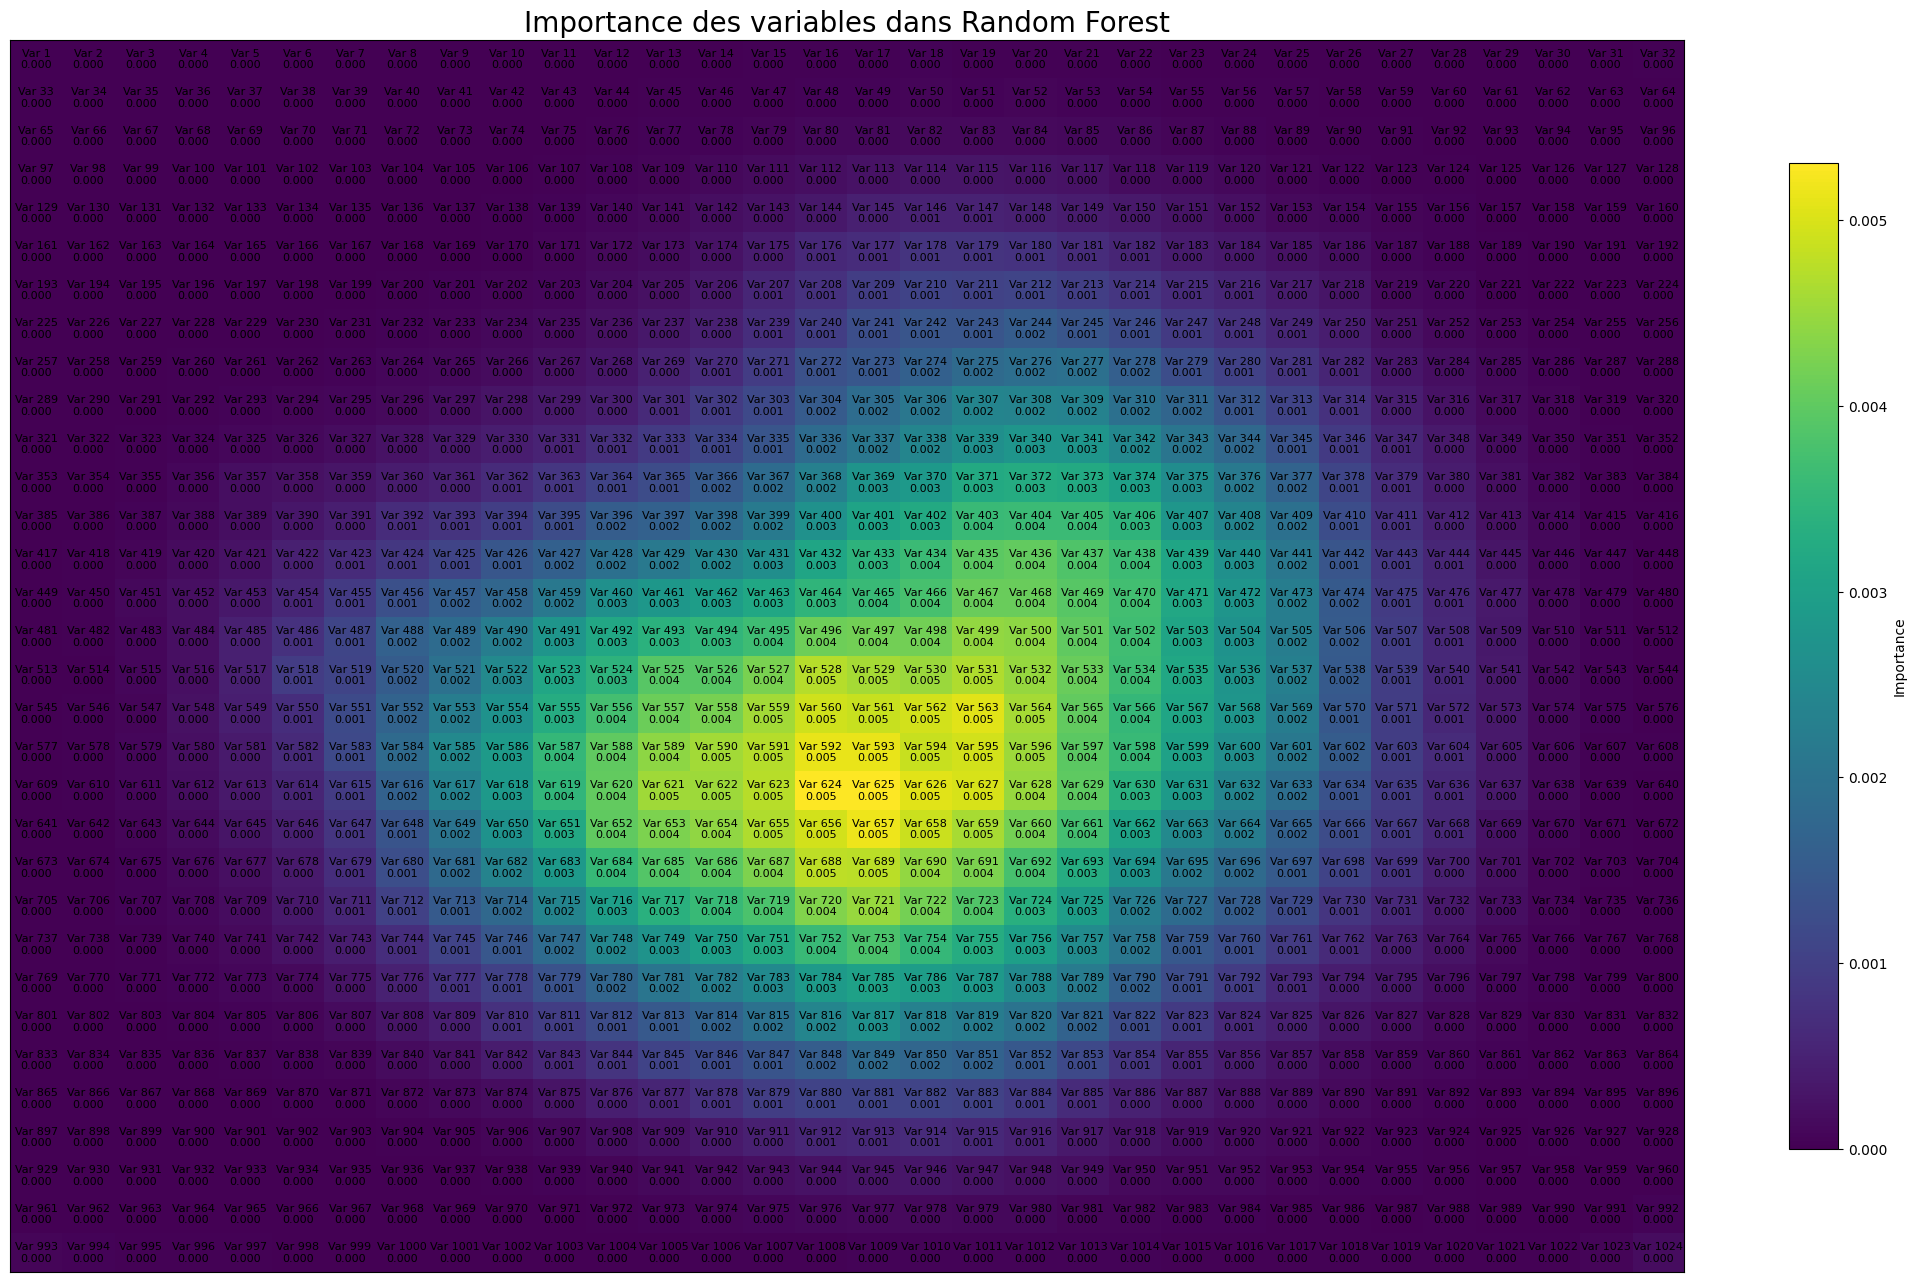

In [20]:
important = rf.feature_importances_ 
num_variables = len(important)
cols = 32
rows = int(np.ceil(num_variables / cols))   
importance_padded = np.pad(important, (0, rows * cols - num_variables), constant_values=np.nan)
importance_grid = importance_padded.reshape(rows, cols)
plt.figure(figsize=(27, 16))
plt.imshow(importance_grid, aspect="auto", interpolation="nearest")
plt.colorbar(label="Importance", shrink=0.8)
plt.title("Importance des variables dans Random Forest", fontsize=20)
for i in range(rows):
    for j in range(cols):
        index = i * cols + j + 1
        if index <= num_variables:  
            plt.text(j, i, f"Var {index}\n{importance_grid[i, j]:.3f}",
                     ha="center", va="center", color="black", fontsize=8)
plt.xticks([])
plt.yticks([])
plt.show()

On observe que les pixels (ou variables) situés au centre d'une image contribuent le plus à la prédiction du modèle de forêt aléatoire.

## 4. AdaBoost
Nous avons observé précédemment que, même avec la forêt aléatoire, le modèle parvient à prédire correctement environ 67 % des observations sur l'ensemble de test et également sur l'ensemble out-of-bag, ce qui n'est pas très performant. Dans cette section, nous allons utiliser AdaBoost, qui est un autre modèle appartenant à la même famille de méthodes ensemblistes que la forêt aléatoire, pour évaluer si cette méthode peut surpasser la forêt aléatoire sur ces données. Nous choisissons comme modèle de base un arbre de décision de profondeur 5, qui offre des performances fiables et est bien adapté à AdaBoost. Ensuite, nous effectuerons une recherche par grille pour optimiser l'hyperparamètre **learning rate**, en utilisant une validation croisée.

- Contrairement au modèle RandomForest qui utilise le principe du bagging et aggrège ainsi les prédictions des différents arbres, AdaBoost utilise le principe du boosting, ou chaque estimateur va apprendre des erreurs des précedents.

**Remarque**  

Il faut choisir un **learning rate** tel que **learning rate × n_estimators > 1**.

In [27]:
from sklearn.ensemble import AdaBoostClassifier  

In [28]:
base_model = DecisionTreeClassifier(max_depth=20, random_state=1)
param_grid = {'learning_rate': [0.1, 0.5]}

In [29]:
adaboost = AdaBoostClassifier(estimator=base_model, n_estimators=200, algorithm='SAMME')  
grid_search = GridSearchCV(adaboost, param_grid, cv=stratified_kfold, scoring='accuracy',n_jobs=-1)  
grid_search.fit(X_train, y_train)
best_pram = grid_search.best_params_
best_acc_grid_ada = grid_search.best_score_
print("Meilleure performance (validation croisée) : ", best_acc_grid_ada)

Meilleure performance (validation croisée) :  0.6377777777777778


Après une recherche par grille avec validation croisée, nous avons trouvé que le meilleur paramètre de learning rate est 0.1, avec un score moyen d'accuracy pour la validation croisée de 0.64.

In [30]:
adaboost.set_params(
    learning_rate = best_pram['learning_rate']
)
adaboost.fit(X_train,y_train)
y_pred = adaboost.predict(X_test)

test_acc_ada = accuracy_score(y_pred=y_pred, y_true=y_test)
print("Précision sur le jeu de test :", test_acc_ada)

Précision sur le jeu de test : 0.6616666666666666


On observe qu'avec Adaboost, il n'y a pas de nette amélioration par rapport à la forêt aléatoire. Le modèle affiche une accuracy de 0,65 sur l'ensemble de test, ce qui est proche de la précision moyenne obtenue lors de la validation croisée. Cela ne suggère pas d'effet de surapprentissage.

# IV - Conclusion
---
<br>

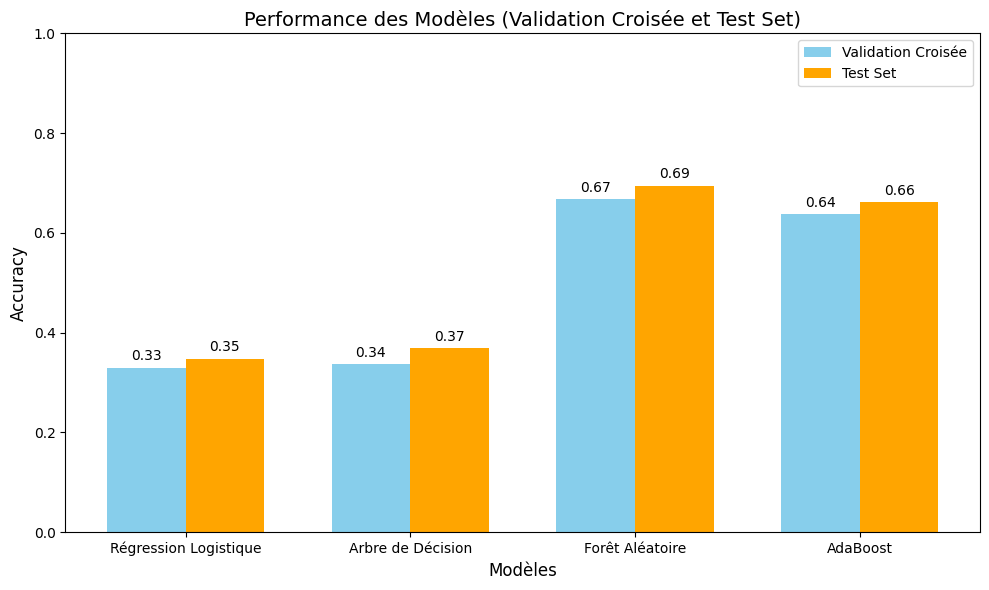

In [31]:
models = ["Régression Logistique", "Arbre de Décision", "Forêt Aléatoire", "AdaBoost"]
validation_scores = [mean_cv_reglog, best_score_tree, rf_grid_best_score, best_acc_grid_ada]
test_scores = [acc_test_reglog, acc_test_tree, rf_test_acc, test_acc_ada]
x = np.arange(len(models))  
width = 0.35  
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, validation_scores, width, label='Validation Croisée', color='skyblue')
bars2 = ax.bar(x + width/2, test_scores, width, label='Test Set', color='orange')
ax.set_xlabel('Modèles', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Performance des Modèles (Validation Croisée et Test Set)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=10)
ax.legend(fontsize=10)
ax.set_ylim(0, 1)  
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', 
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

### **Conclusion**
---

##### **Performances:**
- Les modèles de régression logistique et d'arbres de décision ont montré des signes d'underfitting. Cela suggère que ces modèles ne sont pas suffisamment complexes pour capturer les motifs dans les données de caractères manuscrits arabes

- Les modèles **Random Forest** et **AdaBoost** ont donné des résultats plus prometteurs. Cependant, bien que l'exactitude obtenue soit correcte, elle reste modeste. **Random Forest** a atteint une précision d'environ **70%** et **AdaBoost** a montré des performances légèrement inférieures, avec environ **66% d'exactitude**

- **Avantage de Random Forest**: **Random Forest** a présenté l'avantage d'atteindre une précision décente tout en étant plus rapide à l'entraînement par rapport à **AdaBoost**

##### **Possibilités d'améliorations:**

- Bien que les performances des modèles puissent être améliorées par une meilleure recherche des hyperparamètres, l'augmentation de l'espace de recherche pour ces derniers se traduit par un coût computationnel trop élevé pour notre matériel.

- L'analyse des données a permis de mettre en évidence que la majorité des pixels importants pour la classification des caractères manuscrits se trouvent au centre de l'image. Cette observation pourrait être utilisée pour réduire la taille des images ou se concentrer sur des régions d'intérêt, réduisant ainsi la complexité du modèle en acceptant une perte d'informations mineure.